# Tehtävä 2-1. Aihe: Neuroverkko käsin: 4 pistettä

Tehtävässä on määritetty koordinaattipareja, joiden avulla on piirretty kaksi eri väristä pisteitä.
Tavoitteena on luoda neuroverkko, joka jakaa kuvaajan punaiseen ja siniseen alueeseen.
Kun kuvaajaan piirretään uusi piste ja pisteen koordinaatit syötetään neuroverkolle, neuroverkko ennustaa,
minkä värinen piste on ja samalla sen, että millä todennäköisyydellä se on sen värinen.

1. Luo opetusdatan koordinaattipisteet sekä värit ominaisuuksiin ja ennustettaviin arvoihin.
2. Luo neuroverkkoluokka, jonka rakenne on:
    * Sisääntulokerros, jossa on kaksi neuronia (x, y) - eli koordinaatit pisteelle
    * Yksi piilotettua kerros, jossa on 6 neuronia ja aktivointifunktiona sigmoid.
    * Ulostulokerros, jossa yksi neuroni ja aktivointifunktiona sigmoid.
    * Ulostulokerroksen tulos on siis numeerinen arvo (float) väliltä [0, 1]
3. Luo funktiot, joiden avulla lasket neuroverkon ennustuksen syöttödatalle (forwardpropagation) ja päivität yhteyksien painoarvoja virheen avulla (backpropagation)
4. Syötä koulutusdata 1000 kertaa neuroverkon läpi.
    * Syötä jokaisella kierroksella koulutusdata rivi riviltä neuroverkon läpi ja päivitä painoarvot.
    * Tallenna kierroksen aikana virheet jokaiselle syötölle, ja lisää kierroksen virheistä keskiarvo listaan. Piirrä kuvaaja siitä, kuinka virhe muuttuu koulutuksen aikana
5. Ennusta neuroverkolla (float-arvo), minkä värinen on piste: [0.5, 8.7]. Kuinka tarkka ennuste mielestäsi on?
6. Ennusta neuroverkolla (float-arvo), minkä värinen on piste: [15, -15]. Kuinka tarkka ennuste mielestäsi on?
7. Tutki miten backpropagation()-metodin learning_rate-argumentin muutos vaikuttaa (0.01 -- 0.001) tulokseen?
8. Tutki miten make_blobs()-funktion n_samples-ominaisuuden muuttaminen vaikuttaa tulokseen?
9. Tutki miten make_blobs()-funktion cluster_std-ominaisuuden muuttaminen vaikuttaa tulokseen?


Vinkkejä:
* Piirrä neuroverkon rakenne piirrustusohjelmalla tai paperille, näet silloin yhteyksien määrän jokaisessa kerroksessa.
* Käytä olemassa olevaa ratkaisua materiaaleista, lisää siihen tarvittavat laskut jokaiselle kerrokselle.

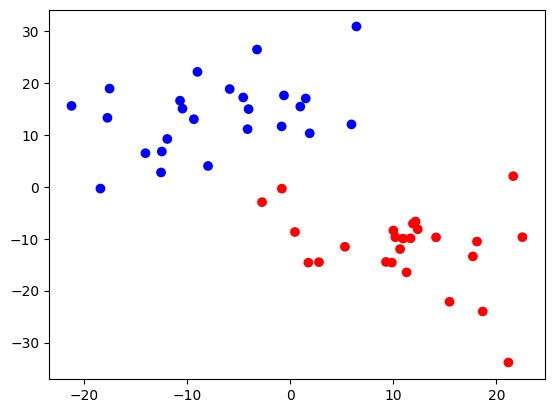

In [116]:
# tehtävässä käytetään make_blobs()-funktiota, jota voi käyttää testidatasetin piirtoon
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
dots, labels = make_blobs(n_samples=50, centers=2, cluster_std=8, center_box=(-20, 20), random_state=151)
colors = ['red' if label == 0 else 'blue' for label in labels]
plt.scatter(dots[:,0],dots[:,1],color=colors)

In [117]:
import numpy as np

# Tehtävän toteutus - tämä on valmis luokka käytettäväksi
class NeuralNetwork:
    def __init__(self):
        self.weights1 = np.random.rand(2, 6)
        self.weights2 = np.random.rand(6, 1)

    def __init__(self, input_neurons, hidden_neurons):
        self.weights1 = np.random.rand(input_neurons, hidden_neurons)
        self.weights2 = np.random.rand(hidden_neurons, 1)

    # Virhefunktio
    def loss_function(self, true, prediction):
        return 0.5 * (true - prediction) ** 2

    # Virhefunktion derivaatta
    def loss_function_derivative(self, true, prediction):
        return true - prediction

    # Sigmoid funktio
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Sigmoidin derivaatta
    def sigmoid_derivative(self, x):
        return x * (1 - x)

    # Neuroverkon läpikäynti
    def forwardpropagation(self, X, y):
        self.X = X
        self.y = y
        self.layer1 = self.sigmoid(np.dot(self.X, self.weights1))
        self.output = self.sigmoid(np.dot(self.layer1, self.weights2))

        # lasketaan häviö eli neuroverkon ennustuksen etäisyys oikeasta arvosta
        self.loss = self.loss_function(self.y, self.output)

    # Painoarvojen päivitys backpropagation - menetelmällä
    def backpropagation(self, learning_rate):
        output_error = self.loss_function_derivative(self.y, self.output)
        output_delta = output_error * self.sigmoid_derivative(self.output)
        weights2_adjustment = np.dot(self.layer1.T, output_delta)

        layer1_error = np.dot(output_delta, self.weights2.T)
        layer1_delta = layer1_error * self.sigmoid_derivative(self.layer1)
        weights1_adjustment = np.dot(self.X.T, layer1_delta)

        self.weights1 += learning_rate * weights1_adjustment
        self.weights2 += learning_rate * weights2_adjustment


 `create_dots_and_labels()`: luodaan pisteet ja nimekkeet sekä nimikkeiden pohjalta asetetaan RGB-väri pisteelle.
 * Opiskelijan tulee toteuttaa seuraava: Luo väritaulukko, jossa väri on `[label: 0: "red" tai 1: "blue"]`
 * Selvitä miten `make_blobs()` toimii

 `train_neural_network()`: Kouluttaa neuroverkon ja tallentaa häviön joka epoch-kierroksen jälkeen (valmis toteutus)

ks. **TODO** -kohdat, jotka vaativat oman koodin kirjoittamista

In [120]:
# funktio palauttaa taulukon, jossa on [dots, labels, colors]
def create_dots_and_labels(n_samples= 50):
    # Generoidaan satunnaisia datapisteitä ja niiden klustereita kahden keskuksen ympärille
    dots, labels = make_blobs(n_samples, centers=2, cluster_std=8, center_box=(-20, 20), random_state=151)
    colors = {0:'red', 1:'blue'}
    # Luo väritaulukko, jossa väri on ["red" tai "blue"]

    return [dots, labels, colors]

# Kouluttaa neuroverkon ja tallentaa häviön joka epoch-kierroksen jälkeen (valmis toteutus)
def train_neural_network(ntwrk, train_X, train_y,learning_rate=0.01):
    losses_arr = []  # tallentaa kierroksen virheet
    epochs = 1000 # Koulutuksen kierrosten määrä
    for epoch in range(epochs):
        batch_losses = []
        # Käydään läpi jokainen koulutusdatapiste (koordinaattipari) yhdessä vastaavan tuloksen kanssa
        for X, y in zip(train_X, train_y):
            # Suoritetaan etenemisvaihe, jossa syötetään data verkolle ja lasketaan ennuste
            ntwrk.forwardpropagation(np.array([X]), np.array([y]))
            # Suuri oppimisnopeus (0.01) voi aiheuttaa ylihyppyjä lähellä optimipistettä
            # Pienempi oppimisnopeus (0.001) on vakaampaa, mutta se voi vaatia enemmän koulutuskierroksia konvergenssin saavuttamiseksi.
            ntwrk.backpropagation(learning_rate)
            batch_losses.append(ntwrk.loss[0]) # Yhden erän virheen tallennus
        losses_arr.append(np.average(batch_losses))  # lasketaan keskiarvo yhden kierroksen virhearvoista
    return losses_arr

# Kokeilee eri oppimisnopeuksia ja tallentaa virheet
def learning_rate(ntwrk,train_X, train_y,learning_rates):
    losses = {}
    for learning_rate in learning_rates:
        # Kouluttaa neuroverkkoa käyttäen annettua oppimisnopeutta ja tallentaa virheiden määrän
        loss = train_neural_network(ntwrk,train_X, train_y,learning_rate)
        losses[learning_rate] = loss
    return losses

* Määritetään koulutusdata ja luodaan neuroverkko
    * create_dots_and_labels
* Piirretään pisteet (kuviotyyppinä `scatter plot`)
* Koulutetaan neuroverkkoa  ja otetaan joka kierroksen jälkeen neuroverkon häviö ylos

In [121]:
 """
 Tehtävän toteutus jatkuu tästä
 TODO: Luodaan ja koulututaan neuroverkko
 ... NeuralNetwork(sisaantulokerroksen_neuronit, piilokerroksen_neuronit) # ks. ohjeen kohta 2.
 ... train_neural_network(...) """

# Luodaan ja koulututaan neuroverkko ja otetaan joka kierroksen jälkeen neuroverkon häviö ylos
simple_network = NeuralNetwork(input_neurons= 2,hidden_neurons=6)
epoch_losses = train_neural_network(simple_network,dots,labels)

Piirretään neuroverkon häviöt

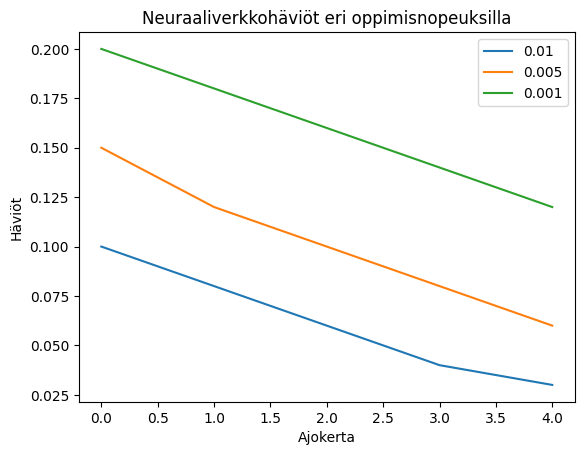

Koodin suorittaminen kesti: 0.1256108283996582 sekuntia


In [122]:
import matplotlib.pyplot as plt
import time

# Asetetaan aikaleima ennen koodin suorittamista
start_time = time.time()
# Luo esimerkkidataa losses_dict-sanakirjalle
losses_dict = {
    0.01: [0.1, 0.08, 0.06, 0.04, 0.03],
    0.005: [0.15, 0.12, 0.1, 0.08, 0.06],
    0.001: [0.2, 0.18, 0.16, 0.14, 0.12]
}
# Piirretään kaavio eri oppimisnopeuksien häviöistä
fig, ax = plt.subplots()
for (lr, loss) in losses_dict.items():
    ax.plot(loss, label=str(lr))
ax.set_title("Neuraaliverkkohäviöt eri oppimisnopeuksilla")
ax.set_xlabel("Ajokerta")
ax.set_ylabel("Häviöt")
ax.legend()
plt.show()

# Lasketaan kulunut aika ja tulostetaan se
end_time = time.time()
elapsed_time = end_time - start_time
print("Koodin suorittaminen kesti:", elapsed_time, "sekuntia")


##### Suuri oppimisnopeus (0.01) voi aiheuttaa ylihyppyjä lähellä optimipistettä
##### Pienempi oppimisnopeus (0.001) on vakaampaa, mutta se voi vaatia enemmän koulutuskierroksia konvergenssin saavuttamiseksi.

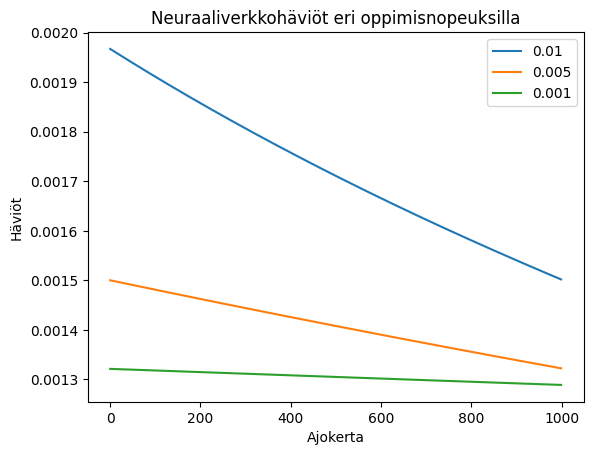

Koodin suorittaminen kesti: 9.986408233642578 sekuntia


In [123]:
# Asetetaan aikaleima ennen koodin suorittamista
start_time = time.time()

# Generoidaan datapisteet ja klusterit
values = create_dots_and_labels(100)
# Koulutetaan neuroverkko ja tallennetaan ajohäviöt
epoch_losses = train_neural_network(simple_network, values[0], values[1])
# Luodaan sanakirja eri oppimisnopeuksien ajohäviöille
losses_dict = learning_rate(simple_network, values[0], values[1], [0.01, 0.005, 0.001])

# Piirretään kaavio eri oppimisnopeuksien virheistä
fig, ax = plt.subplots()
for (lr, loss) in losses_dict.items():
    ax.plot(loss, label=str(lr))
ax.set_title("Neuraaliverkkohäviöt eri oppimisnopeuksilla")
ax.set_xlabel("Ajokerta")
ax.set_ylabel("Häviöt")
ax.legend()
plt.show()

# Lasketaan kulunut aika ja tulostetaan se
end_time = time.time()
elapsed_time = end_time - start_time
print("Koodin suorittaminen kesti:", elapsed_time, "sekuntia")

### Lasketaan ennusteet
* laske `output1`-muuttujaan neuroverkon ennuste syötteelle `[0.5, 8.7]`.
* laske `output2`-muuttujaan neuroverkon ennuste syötteelle `[-30, -30]`.


In [124]:
#Ennusteiden laskeminen yo. kahdelle pisteille

# Lasketaan ennuste ensimmäiselle syötteelle
test_X_nn = np.array([0.5, 8.7])
# layer1_output = neural_network.sigmoid(np.dot(numpy_array, painoarvot))
# annetaan edellisen kerroksen tulokset ja toiset painoarvot edellä käytetylle funktiolle
layer1_output = simple_network.sigmoid(np.dot(test_X_nn, simple_network.weights1))
output1 = simple_network.sigmoid(np.dot(layer1_output, simple_network.weights2))

test_X_nn2 = np.array([15, -15])
# Lasketaan ennuste toiselle syötteelle

test_X_nn2 = np.array([-30, -30])
layer2_output = simple_network.sigmoid(np.dot(test_X_nn2, simple_network.weights1))
output2 = simple_network.sigmoid(np.dot(layer2_output, simple_network.weights2))

In [125]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän.
print(output1)
print(output2)

[0.99275832]
[0.00374619]


# Tehtävä 2-2
# Aihe: Yksinkertainen neuroverkko Keras Sequential API:lla (max. 3 p)

Koulutetaan yksinkertainen neuroverkko **Keras**-rajapinnalla käyttäen `titanic-dataa`
Datan saat osoitteesta: `https://student.labranet.jamk.fi/~varpe/datananalk2019/kerta10/titanic.csv`

Tehtävästä on löydyttävä vaiheet:
1. Valitse Titanic-datasta vain kolme-neljä tärkeää feature-piirrettä tehtävään
   * tästä aineistosta on ollut esimerkkejä jo koneoppimisen puolella (ja niitä voi lainata tai soveltaa), mutta tätä voi halutessaan myös itse tutkia tarkemmin
2. Luo neuroverkko (käytä `tf.keras.Sequential()`-metodia)
3. Määritä häviöfunktio ja optimisaattori (käytä `model.compile()`-metodia)
4. Kouluta neuroverkko (käytä `model.fit()`-metodia)
5. Vertaa neuroverkon antamia ennustuksia testidataan (käytä `model.evaluate()`-metodia)
6. Tulosta välikierrosten (`epoch`) tulokset konsolille.
 ```
 23/23 [==============================] - 0s 687us/step - loss: 2.2182 - accuracy: 0.6236
 Epoch 2/1000
 23/23 [==============================] - 0s 702us/step - loss: 1.4468 - accuracy: 0.6238
 ```
7. Muuta neuroverkon rakennetta ja yritä dokumentoida neuroverkko, jolla sait parhaat tulokset.

Myös epoch-kierrosmäärien vaikutusta voi testata, mutta arvauksena on, että max. 1000 opetuskierrosta riittää varmasti hyvin.
Useita neuroverkkorakenteita kannattaa kokeilla ja hieman vertailla oppimistuloksia.


### Datan esikäsittely + Keras - Titanic-data

Versio, jossa pyritään hakemaan 3-4 tärkeintä piirrettä, jotka korreloivat eniten `survived`-kentän (luokkamuuttujan) kanssa.


In [1]:
# Tehtävän toteutus
# Datan Esikäsittely

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv('https://student.labranet.jamk.fi/~varpe/datananalk2019/kerta10/titanic.csv')

print(df.head())
print(df.columns)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
In

In [2]:
# Muutetaan sukupuolet numeroiksi
from sklearn.preprocessing import OneHotEncoder
result = OneHotEncoder().fit_transform(df["Sex"].values.reshape(-1, 1)).toarray()

# Female = 0, male = 1
df["Sex"].replace(["female","male"],[0,1],inplace=True)

In [3]:
# Ikäryhmiin jako ylimallintamisen välttämiseksi
bins = [0, 18, 40, 100]
df["Agegroup"] = pd.qcut(df["Age"], labels=False,q=4)

In [4]:
df["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [5]:
df.groupby([df["Agegroup"], df["Sex"]])["Survived"].sum()

Agegroup  Sex
0.0       0      53
          1      29
1.0       0      47
          1      19
2.0       0      51
          1      25
3.0       0      46
          1      20
Name: Survived, dtype: int64

In [6]:
# Tarkistetaan puuttuvat iät
null_age = df.query("Age.isnull()", engine = "python")

In [7]:
null_age["Survived"].value_counts()

Survived
0    125
1     52
Name: count, dtype: int64

* Jos henkilöltä puuttuu ikätiedot, on selviytymismahdollisuudet pienet

In [8]:
# Poistetaan puuttuvat arvot
X = df[["Sex", "Pclass", "SibSp", "Survived"]] # Valitaan sex, pclass, sibsp, survived
X = X.dropna()
y = X["Survived"]
X.drop(columns=["Survived"], inplace = True)

### Aineiston jakaminen
* Irrotetaan ennustettava muuttuja datasta.
* jaetaan data opetus- ja testidataan.


In [16]:
# Tehtävän toteutus
# TODO: Irrotetaan datasta ennustettava luokkamuuttuja
# TODO: Jako opetus- ja testidataan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=9001)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

### Tehtävän toteutus Keras-kirjastoa käyttäen

Luodaan neuroverkko, jossa on `Dense`-kerroksia peräkkäin (`Sequential`). Määritä nämä kaksi parametriä ainakin:
* `units` – dimensionality of the output space.
* `activation` – Activation function to use. If you don't specify anything, no activation is applied

Huom! Useita neuroverkkorakenteita kannattaa kokeilla ja hieman vertailla oppimistuloksia.

In [113]:
# Tehtävät toteutus
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Dense,Input
tf.keras.backend.set_floatx('float64')

# Luodaan verkkomalli
opt = Adam(learning_rate=0.001) # Määritetään optimoija Adam oppimisnopeudella 0.01
classifier = Sequential() # Luodaan sekventiaalinen neuroverkkomalli
input_layer =  Input(shape=(6)) # Määritetään syötekerros, jolla on 6 piirrettä
classifier.add(input_layer)
# Lisätään tiheä kerros (Dense) 16 neuronilla, käyttäen sigmoid-aktivaatiota
dense1 = Dense(32,activation="sigmoid")
classifier.add(dense1)
# Lisätään lähtökerros (Dense) yhdellä neuronilla ja sigmoid-aktivaatiolla
output_layer = Dense(1,activation="sigmoid")
classifier.add(output_layer)

* Määritetään häviöfunktio ja optimisaattori.
* Koulutetaan neuroverkko (epochs=100-1000)
* Verrataan tuloksia testidataan

In [114]:
# Tehtävän toteutus
# TODO: Käännä malli
# TODO: Kouluta neuroverkko n epoch-kierrosta

classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train, y_train,epochs=300, batch_size = 32)
# Evaluiodaan neuroverkko testijoukolla
results = classifier.evaluate(X_test, y_test, verbose=1)

Epoch 1/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6237 - accuracy: 0.6967
Epoch 2/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6206 - accuracy: 0.6967
Epoch 3/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6185 - accuracy: 0.6967
Epoch 4/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6154 - accuracy: 0.6967
Epoch 5/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6134 - accuracy: 0.6967
Epoch 6/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6111 - accuracy: 0.6967
Epoch 7/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6094 - accuracy: 0.6967
Epoch 8/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6074 - accuracy: 0.6967
Epoch 9/300
4/4 [==============================] - 0s 834us/step - loss: 0.6056 - accuracy: 0.6967
Epoch 10/300
4/4 [==============================] - 0s 1ms/step - loss: 0.6034 - accuracy: 0.6967
Epoch 11/300
4/4 [=========

In [126]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita results - muuttujaan funktion model.evaluate() tulos.
# TODO: Muista määrittää model.compile() - funktioon seurattavaksi suureeksi metrics=['accuracy'] neuroverkon ennustuksien tarkkuuden määrittelemiseksi.
print(f"Test Loss:{results[0]} Test Accuracy:{results[1]*100}%")

Test Loss:0.7187942468861774 Test Accuracy:67.21311475409836%


Tehtävän tuloksesta:
Test Accuracy: > n. 80 % -- on jo aika hyvä, mutta toki parempaakin saa hakea (jos haluaa käyttää paljon ylimääräistä aikaa)


Test Accuracy on 67 %, joka on huono. Tähän auttaa muun muassa se, jos käyttää eri aktivaatiofunktioita kuten ReLu tai vaikka tanh.